# Neural Network Intro

**Summary of Article**
- Theoretical Introduction to Neural Networks.
- FeedForward Neural Network Implementation for Regression.
- FeedForward Neural Network Implementation for Classification.



## Neural Network Intro
### Theoretical Introduction to Neural Networks
Neural Networks (NN)  are a class of ML models that are based on the connections of layers of artificial neurons. The connections between the layers are made up of weights and biases, that are updated during the training process. Activation functions are used to determine the output of a neuron. Different activation functions are what allow the NN to learn and generalize expressive results. The following illustration represents the architecture of a neural network. (Only on thesis)
** Figure here **.
### Training Process 
The training process of a NN is the process of updating the weights and biases of the neural network to make it better at predicting the output of the input. Backpropagation is a method of updating the weights and biases, where the derivative of the loss fuction with respect to the weights and biases, is used to update the respective values. The training process takes the following steps:

- Take a batch of training data.
- Forward propagate the batch of data through the neural network.
- Compute the loss function for the batch of data.
- Backpropagate the loss function to get the gradients.
- Update the weights and biases using the gradients.
- Repeat the above steps until the loss function is less than a determined threshold.

The most common activation function are: 
- Sigmoid function: $$g(z) = \frac{1}{1+e^{-z}}$$
- Tanh: $$ g(z)= \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}}$$
- ReLu: $$ g(z) = \max(0,z)$$

The most common Loss functions for Regression is:
- RMSE: $$L(z,y) = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - z_i)^2}$$


## Training a Neural Network with PyTorch 
Now Pytorch will be used to train a neural network. The data will be the sparse dataset normalized.

In [1]:
import pandas as pd
import torch
import sys; sys.path.append('..')
from thesis_package import utils

c:\Users\jamil\Documents\IST\Thesis\new_thesis\code\AI-to-forecast-constraints-in-the-energy-systems\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The first step is to create the data set class. Our data set class will extend `torch.utils.data.Dataset`. Afterwards, we will create the data loader class. The data loader class will extend `torch.utils.data.DataLoader`. The data loader is used to separate the data set in batches, shuffle the data set and create an iterator.

First the dataset is loaded and prepared in tha same fashion as for the other ML models.

In [2]:
y_max_u_bool = pd.read_csv('..\data\ground_truth\\res_bus_vm_pu_max_bool_constr.csv').drop(columns='timestamps')
y_max_u = y_max_u_bool[utils.cols_with_positive_values(y_max_u_bool)]
exogenous_data = pd.read_csv('..\data\processed\production\exogenous_data_extended.csv').drop(columns=['date'])
X_max_u_bool_train, X_max_u_bool_test, y_max_u_bool_train, y_max_u_bool_test, scaler = utils.split_and_suffle(exogenous_data, y_max_u_bool, scaling=True)
data = {'X_train':X_max_u_bool_train.astype(float),
        'X_test': X_max_u_bool_test.astype(float),
        'y_train':y_max_u_bool_train.astype(float),
        'y_test': y_max_u_bool_test.astype(float)
    }

Then the dataset class is declared.

In [3]:
from torch.utils.data import Dataset, DataLoader
class ThesisDataset(Dataset):
    def __init__(self, data) -> None:
        train_X, train_y = data['X_train'], data['y_train']
        test_X, test_y = data['X_test'], data['y_test']
        self.X = torch.from_numpy(train_X.values).float()
        self.y = torch.from_numpy(train_y.values).float()
        self.X_test = torch.from_numpy(test_X.values).float()
        self.y_test = torch.from_numpy(test_y.values).float()
    def __getitem__(self, index) -> tuple:
        return self.X[index], self.y[index]
    def __len__(self) -> int:
        return len(self.X)
dataset = ThesisDataset(data)
dataset[0]

(tensor([0.9355, 0.4582, 0.4807, 0.4887, 1.0000, 0.8571, 0.4955, 0.4880, 0.9356,
         0.7071, 0.4650]),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

Now we create our data loader object.

In [4]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
dataiter = iter(dataloader)
from math import ceil
total_samples = len(dataset)
n_iterations = ceil(total_samples / 32)
print('Total samples: {}, total interations: {}'.format(total_samples, n_iterations))

Total samples: 36172, total interations: 1131


Now our training loop will look like the follwing:

```python	
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(dataloader):
        # Zero grads, Forward, Backwards and Update
    # Compute and print loss
    # Evaluate model on validation set
```

Now, it is necessary to decide on hyperparameters for the neural network. These hyper parameters will later be tunned using optuna.

In [5]:
model_params = {
    'input_size': dataset.X.shape[1],
    'hidden_size': 32,
    'output_size': dataset.y.shape[1],
    'n_layers': 4,
    'dropout': 0.5
}

In [6]:
print(dataset.X.shape[1])
print(dataset.y.shape[1])

11
34


It is important to configure the device once it is faster to train the models oh the GPU, if one is available. Later it is necessary to push th tensors into device.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device # In my case I don't have a GPU, so I use the CPU ... Sad, so if anyone wants to give me a GPU, hit me up on LinkedIn :) 

device(type='cpu')

First, we define a model.

In [8]:
import torch.nn as nn
class FeedforwardNetwork(nn.Module):
    def __init__(
            self, model_params, **kwargs):
        """
        n_classes (int)
        n_features (int)
        hidden_size (int)   
        layers (int)
        activation_type (str)
        dropout (float): dropout probability
        As in logistic regression, the __init__ here defines a bunch of
        attributes that each FeedforwardNetwork instance has. Note that nn
        includes modules for several activation functions and dropout as well.
        """
        super(FeedforwardNetwork, self).__init__()
        output_size, input_size, hidden_size, n_leayers, dropout = model_params['output_size'], model_params['input_size'], model_params['hidden_size'], model_params['n_layers'], model_params['dropout']
        layers = []
        for i in range(n_leayers):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_size))
            else:
                layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Tanh())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_size, output_size))
        self.feedforward_nn = nn.Sequential(*layers)
    def forward(self, x, **kwargs):
        """
        x (batch_size x n_features): a batch of training examples
        This method needs to perform all the computation needed to compute
        the output logits from x. This will include using various hidden
        layers, pointwise nonlinear functions, and dropout.
        """
        return self.feedforward_nn(x)

In [9]:
model = FeedforwardNetwork(model_params)
model

FeedforwardNetwork(
  (feedforward_nn): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): Tanh()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=32, out_features=34, bias=True)
  )
)

Now we define the `train_batch()` function. This function will be used to train the model on a batch of data. The train_batch has he following steps:
- Setting the stored gradient values to zero.
- Computes the gradient of the given tensor with respect to the weights and biases.
-  Computes the gradient of the given tensor w.r.t. graph leaves.
- Updates weights and biases with the optimizer (SGD of ADAM)

In [10]:
def train_batch(X, y, model, optimizer, criterion, **kwargs):
    """
    X (n_examples x n_features)
    y (n_examples): gold labels
    model: a PyTorch defined model
    optimizer: optimizer used in gradient step
    criterion: loss function
    To train a batch, the model needs to predict outputs for X, compute the
    loss between these predictions and the "gold" labels y using the criterion,
    and compute the gradient of the loss with respect to the model parameters.
    Check out https://pytorch.org/docs/stable/optim.html for examples of how
    to use an optimizer object to update the parameters.
    This function should return the loss (tip: call loss.item()) to get the
    loss as a numerical value that is not part of the computation graph.
    """
    # Forward
    #print('X shape: {}'.format(X.shape))
    output = model(X)  # Computes the gradient of the given tensor w.r.t. the weights/bias
    #print('output shape: {}, y_shape: {}'.format(output.shape, y.shape))
    loss = criterion(output, y) # cross entropy in this case
    # Backwards
    optimizer.zero_grad()  # Setting our stored gradients equal to zero
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    optimizer.step() # Updates weights and biases with the optimizer (SGD of ADAM)
    return loss.item()
    
def predict(model, X):
    """X (n_examples x n_features)"""
    scores = model(X)  # (n_examples x n_classes)
    return scores

def evaluate(model, X, y):
    """
    X (n_examples x n_features)
    y (n_examples): gold labels
    """
    model.eval()
    y_hat = predict(model, X)
    y_hat = torch.heaviside(y_hat, torch.tensor(0.0))
    n_correct = (y == y_hat).sum().item()
    n_possible = float(y.shape[0])
    model.train()
    return n_correct / n_possible

Plotting function.

In [11]:
import matplotlib.pyplot as plt
def plot(epochs, plottable, ylabel='', title=''):
    plt.clf()
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.plot(epochs, plottable)
    plt.grid()
    plt.title(title)

Training epoch 1
Training loss: 1.9284
Training epoch 2
Training loss: 1.8939
Training epoch 3
Training loss: 1.8542
Training epoch 4
Training loss: 1.8101
Training epoch 5
Training loss: 1.7636
Final Test acc: 25.3266


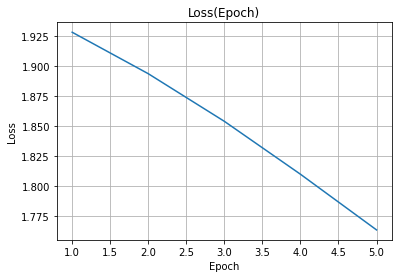

In [12]:
# Data
test_X, test_y = dataset.X_test, dataset.y_test
# initialize the model    
model = FeedforwardNetwork(model_params)
# Hyperparameters
hyper_params = {'optimizer': 'adam', 'lr': 0.001, 'epochs': 5, 'batch_size': 32}
# get an optimizer
optims = {"adam": torch.optim.Adam, "sgd": torch.optim.SGD}
optim_cls = optims["sgd"]
optimizer = optim_cls(
    model.parameters(),
    lr=hyper_params["lr"],
    weight_decay=0.0)

# get a loss criterion
criterion = nn.CrossEntropyLoss()

# training loop
epochs = torch.arange(1, hyper_params['epochs'] + 1)
train_mean_losses = []
valid_accs = []
train_losses = []
for ii in epochs:
    print('Training epoch {}'.format(ii))
    for X_batch, y_batch in dataloader:
        # X = batch_size x 11, y = batch_size x 34
        # Print X_batch.shape, y_batch.shape
        # print('X_batch shape: {}, y_batch shape: {}'.format(X_batch.shape, y_batch.shape))
        loss = train_batch(
            X_batch, y_batch, model, optimizer, criterion)
        train_losses.append(loss)
    mean_loss = torch.tensor(train_losses).mean().item()
    print('Training loss: %.4f' % (mean_loss))

    train_mean_losses.append(mean_loss)
final_acc = evaluate(model, test_X, test_y)
print('Final Test acc: %.4f' % (evaluate(model, test_X, test_y)))
# plot
plot(epochs, train_mean_losses, ylabel='Loss', title='Loss(Epoch)')

In [13]:
prediction = predict(model, test_X)
prediction = torch.heaviside(prediction, torch.tensor(0.0))
prediction = pd.DataFrame(prediction.detach().numpy(), columns=y_max_u_bool.columns)

In [14]:
prediction

,ext_grid,bus_1,bus_2,bus_3,bus_4,bus_5,bus_6,bus_7,bus_8,bus_9,...,bus_30,bus_31,bus_17,bus_21,bus_24,bus_18,bus_23,bus_27,bus_32,bus_33
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9039,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
9040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
9041,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
9042,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [15]:
import sklearn
sklearn.metrics.f1_score(data['y_test'], prediction, average='micro')

0.08962851231835677

In [16]:
print(model.eval())

FeedforwardNetwork(
  (feedforward_nn): Sequential(
    (0): Linear(in_features=11, out_features=32, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): Tanh()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): Tanh()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=32, out_features=34, bias=True)
  )
)


In [26]:
# unscale the X_max_u_bool_train data for plotting.
X_max_u_bool_train_unscaled = scaler['X_train'].inverse_transform(X_max_u_bool_train)
# Each data set has its own scaler in order to be possible to inverse scale.

In [27]:
X_max_u_bool_train_unscaled = pd.DataFrame(X_max_u_bool_train_unscaled, columns=exogenous_data.columns)